### imports

In [1]:
from SEAM.utils import *
import SEAM
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
from sklearn.decomposition import PCA
import re
from scipy.spatial.distance import *
from skimage import color
from skimage.segmentation import *
import imageio
from scipy import ndimage as ndi



/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.


### settings

In [2]:
sns.set_style('white')
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 2}

# matplotlib.rc('font', **font)
# matplotlib.rcParams.update({'font.size': 2})

import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title






### functions

In [3]:

def intersection_over_union(ground_truth, prediction):
    
    # Count objects
    true_objects = len(np.unique(ground_truth))
    pred_objects = len(np.unique(prediction))
    
    # Compute intersection
    h = np.histogram2d(ground_truth.flatten(), prediction.flatten(), bins=(true_objects,pred_objects))
    intersection = h[0]
    
    # Area of objects
    area_true = np.histogram(ground_truth, bins=true_objects)[0]
    area_pred = np.histogram(prediction, bins=pred_objects)[0]
    
    # Calculate union
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    union = area_true + area_pred - intersection
    
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    
    # Compute Intersection over Union
    union[union == 0] = 1e-9
    IOU = intersection/union
    
    return IOU


def measures_at(threshold, IOU):
    
    matches = IOU > threshold
    
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    
    assert np.all(np.less_equal(true_positives, 1))
    assert np.all(np.less_equal(false_positives, 1))
    assert np.all(np.less_equal(false_negatives, 1))
    
    TP, FP, FN = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    
    f1 = 2*TP / (2*TP + FP + FN + 1e-9)
    
    return f1, TP, FP, FN

# Compute Average Precision for all IoU thresholds

def compute_af1_results(ground_truth, prediction, results, image_name,Alg,k,count,Type):

    if not (ground_truth.shape[0]==prediction.shape[0] and ground_truth.shape[1]==prediction.shape[1]):
        axis0_len = min(ground_truth.shape[0],prediction.shape[0])
        axis1_len = min(ground_truth.shape[1],prediction.shape[1])
        ground_truth = ground_truth[0:axis0_len,0:axis1_len]
        prediction = prediction[0:axis0_len,0:axis1_len]
    
    # Compute IoU
    IOU = intersection_over_union(ground_truth, prediction)
    if IOU.shape[0] > 0:
        jaccard = np.max(IOU, axis=0).mean()
    else:
        jaccard = 0.0
    
    # Calculate F1 score at all thresholds
    for t in np.arange(0.05, 1, 0.05):
        f1, tp, fp, fn = measures_at(t, IOU)
        AP = tp/(tp+fp+fn)
        res = {"Image": image_name, 'Type':Type,'Alg':Alg,'Parameter':k,"Threshold": t, "F1": f1, "Jaccard": jaccard, "TP": tp, "FP": fp, "FN": fn,'AP':AP,'Count':count}
        
        row = len(results)
        results.loc[row] = res
        
    return results

def filter_mask(sc,threshold=(2,100)):
    segmented_cells = sc.copy()
    unique_idx,unique_count = np.unique(segmented_cells,return_counts=1)
    filtered_idx = unique_idx[np.where((unique_count>threshold[1]) | (unique_count<threshold[0]))]
    
    segmented_cells[np.isin(segmented_cells,filtered_idx)] = 0
    segmented_cells_new = np.zeros_like(segmented_cells)
    segmented_cells_new[segmented_cells!=0]=1
    segmented_cells_new,_ = ndi.label(segmented_cells_new)
    return segmented_cells_new

    

### get segments

In [4]:
with open('/home/yzy/projects/data_in_ipynb_revision/MIBI_segmentation/Segment__Cut.pickle', 'rb') as handle:
    Cut_mask_dict = pickle.load(handle)

with open('/home/yzy/projects/data_in_ipynb_revision/MIBI_segmentation/Segment_GT.pickle', 'rb') as handle:
    Human_int_dict = pickle.load(handle)


with open('/home/yzy/projects/data_in_ipynb_revision/MIBI_segmentation/Segment_WSedt.pickle', 'rb') as handle:
    WSedt_int_dict = pickle.load(handle)

with open('/home/yzy/projects/data_in_ipynb_revision/MIBI_segmentation/Segment_HMRF.pickle', 'rb') as handle:
    HMRF_int_dict = pickle.load(handle)
with open('/home/yzy/projects/data_in_ipynb_revision/MIBI_segmentation/Segment_RW.pickle', 'rb') as handle:
    RW_int_dict = pickle.load(handle)
with open('/home/yzy/projects/data_in_ipynb_revision/MIBI_segmentation/Segment_Threshold.pickle', 'rb') as handle:
    Threshold_int_dict = pickle.load(handle)
with open('/home/yzy/projects/data_in_ipynb_revision/MIBI_segmentation/Segment_EB.pickle', 'rb') as handle:
    EB_int_dict = pickle.load(handle)


### make alg_name:segment_rst dict for use

In [5]:
Alg_dict = {
    'SIMSCut':Cut_mask_dict,
    'WSedt':WSedt_int_dict,
    'HMRF':HMRF_int_dict,
    'RW':RW_int_dict,
    'Threshold':Threshold_int_dict,
    'EB':EB_int_dict
}

In [95]:
for alg in Alg_dict.keys():
    cur_rst = Alg_dict[alg]
    for p in cur_rst.keys():
        cur_p = cur_rst[p]
        if isinstance(cur_p,np.ndarray):
            img = cur_p.copy()
        else:
            img = cur_p[2].copy()
        img[img>=1]=1
        
        plt.imshow(img,cmap='gray')
#         plt.title('{0}_{1}'.format(alg,p))
#         plt.show()
        plt.axis('off')
        plt.savefig('/home/yzy/projects/data_in_ipynb_revision/MIBI_segmentation_rst/{0}_{1}'.format(alg,p), bbox_inches='tight', pad_inches=0)


In [98]:
for p in Human_int_dict.keys():
    img = Human_int_dict[p].copy()
    img[img>=1]=1

    plt.imshow(img,cmap='gray')
#         plt.title('{0}_{1}'.format(alg,p))
#         plt.show()
    plt.axis('off')
    plt.savefig('/home/yzy/projects/data_in_ipynb_revision/MIBI_segmentation_rst/GT_{0}.png'.format(p), bbox_inches='tight', pad_inches=0)


### create empty result dataframe

In [6]:
results = pd.DataFrame({'Image':[],'Alg':[],'Parameter':[],'Threshold':[],'AP':[],'F1':[],'Jaccard':[],'TP':[],'FP':[],'FN':[]})


### sample name list

In [7]:
tissue_list = [
    'P1','P24'
]
type_list = [
'MIBI'   ,'MIBI' 
]

### 0~20

P1 SIMSCut -1
P1 WSedt 2
P1 WSedt 3
P1 WSedt 4
P1 WSedt 5
P1 HMRF 2
P1 HMRF 3
P1 HMRF 4
P1 HMRF 5
P1 RW 2
P1 RW 3
P1 RW 4
P1 RW 5
P1 Threshold 2
P1 Threshold 3
P1 Threshold 4
P1 Threshold 5
P1 EB -1
P24 SIMSCut -1
P24 WSedt 2
P24 WSedt 3
P24 WSedt 4
P24 WSedt 5
P24 HMRF 2
P24 HMRF 3
P24 HMRF 4
P24 HMRF 5
P24 RW 2
P24 RW 3
P24 RW 4
P24 RW 5
P24 Threshold 2
P24 Threshold 3
P24 Threshold 4
P24 Threshold 5
P24 EB -1


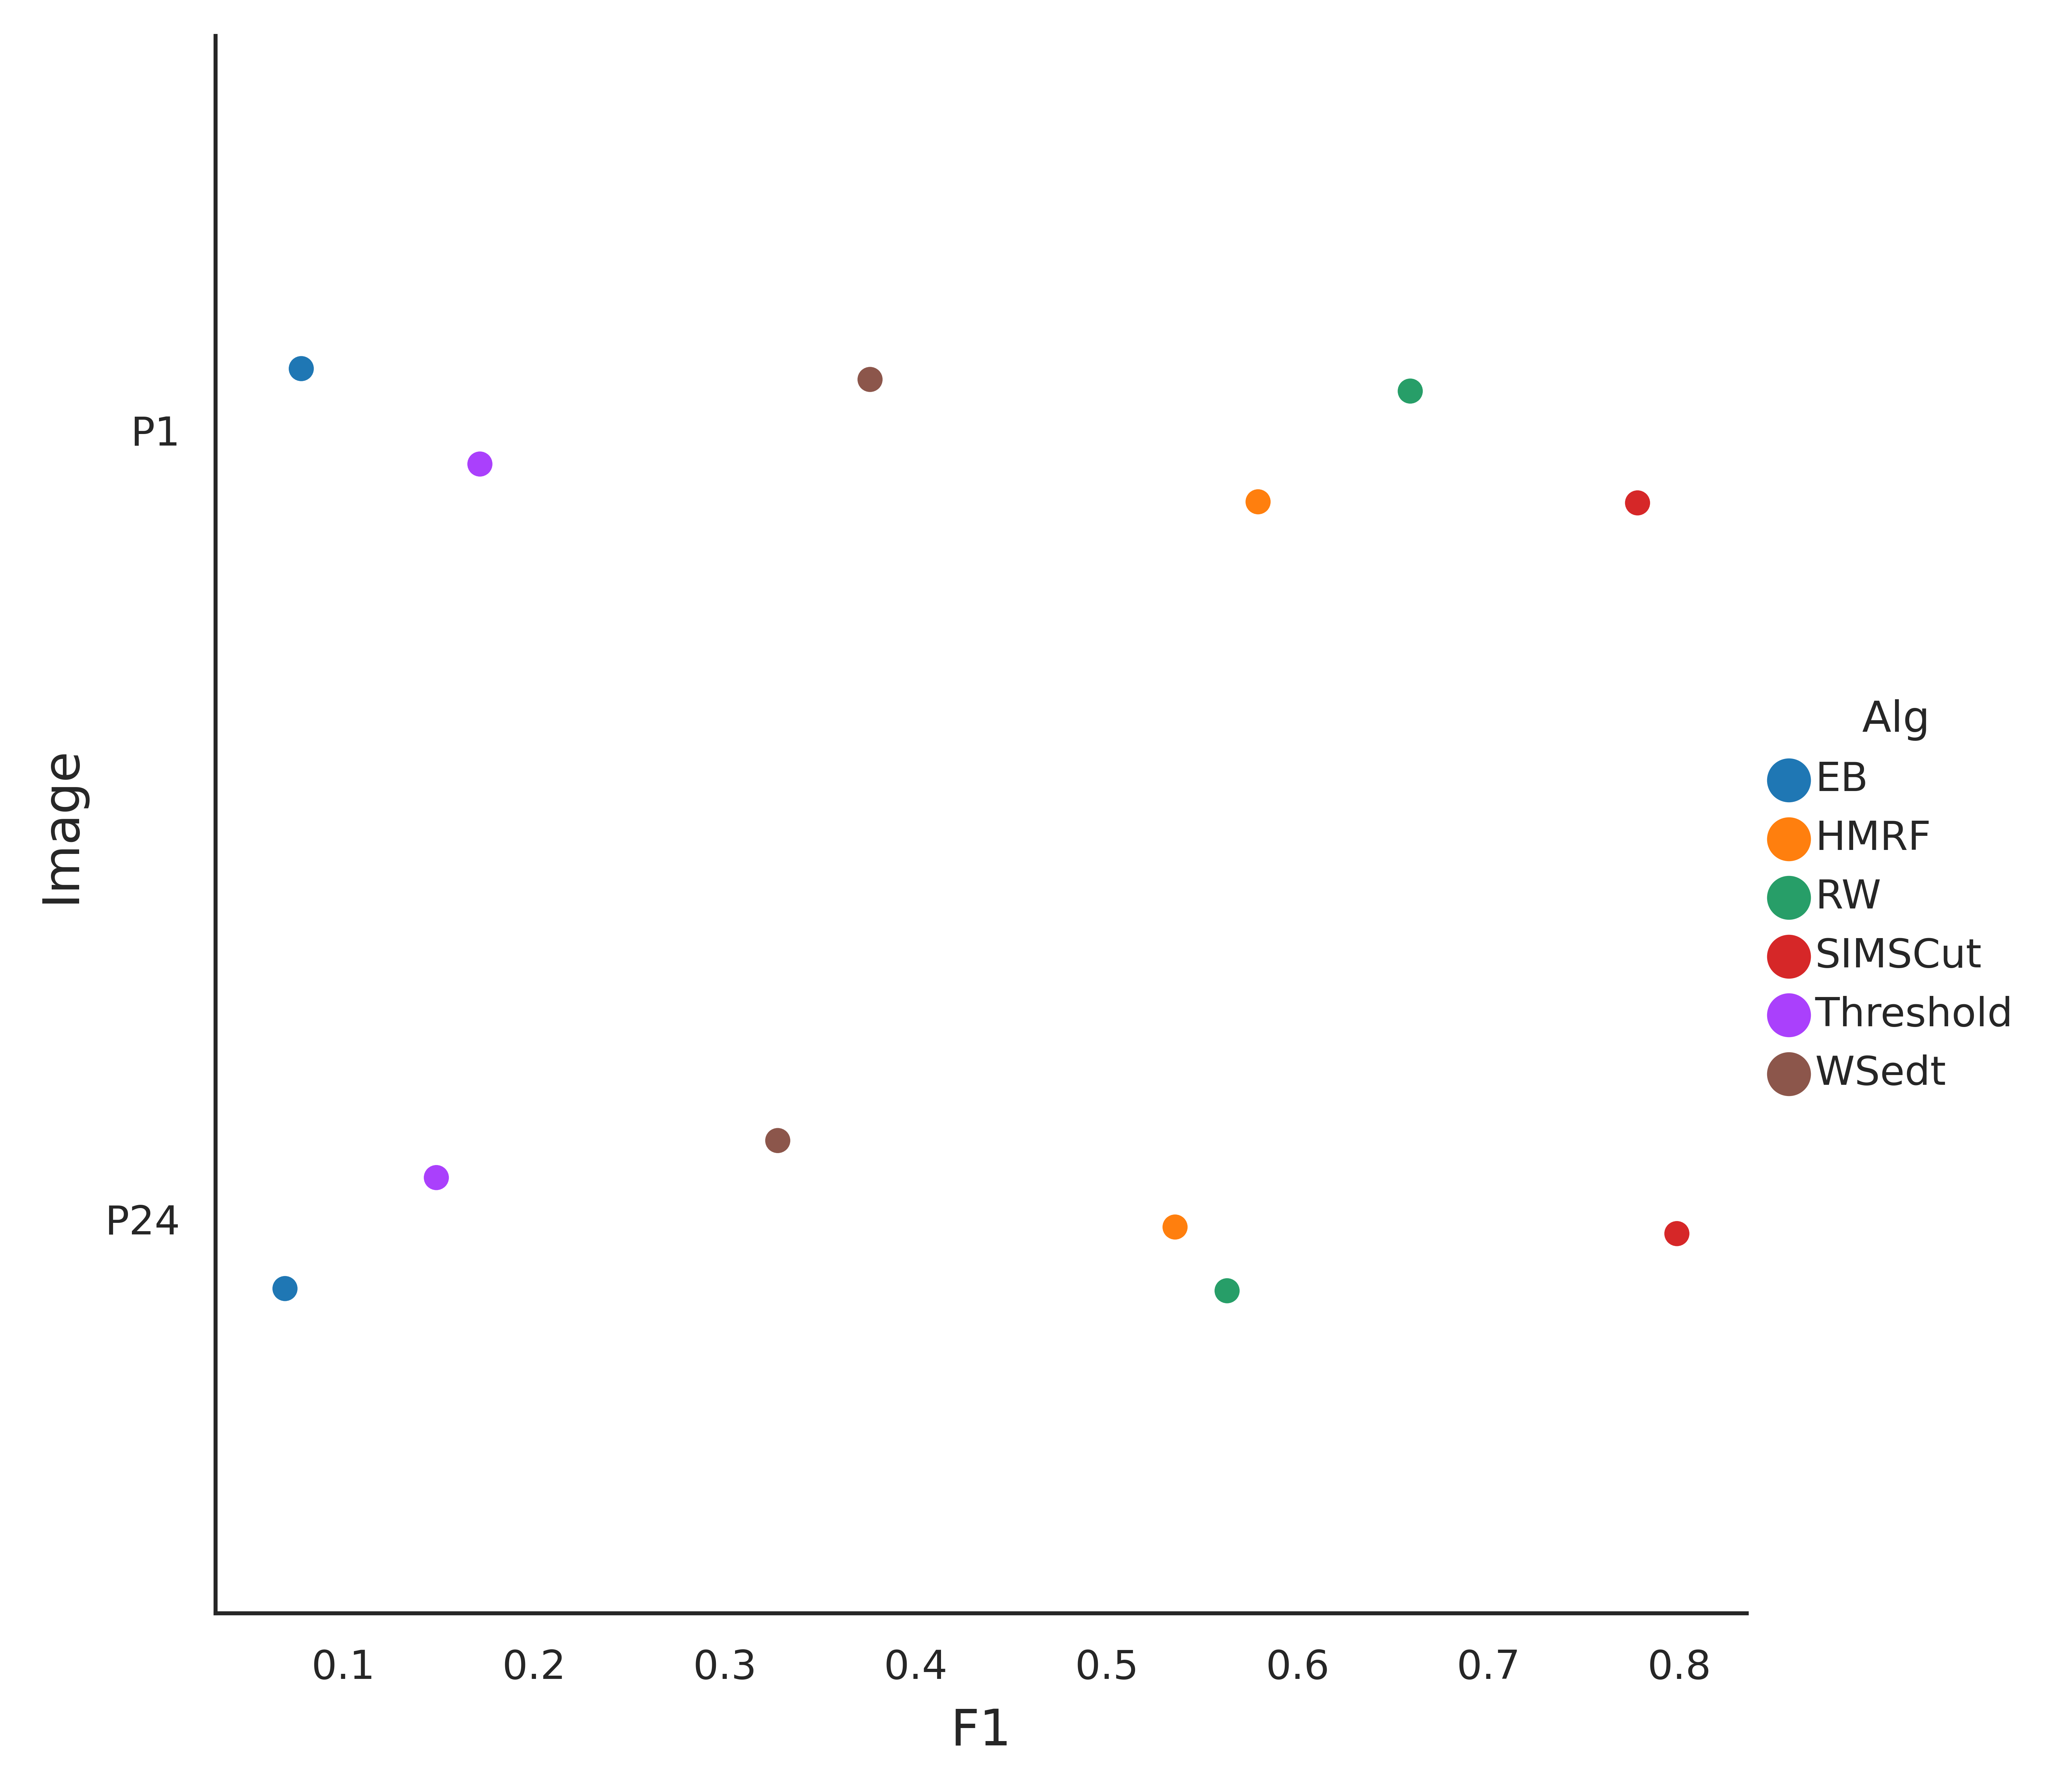

In [84]:
results = pd.DataFrame({'Image':[],'Type':[],'Alg':[],'Parameter':[],'Threshold':[],'AP':[],'F1':[],'Jaccard':[],'TP':[],'FP':[],'FN':[],'Count':[]})

for i in range(len(tissue_list)):
    test_tissue = tissue_list[i]
    cur_human = Human_int_dict[test_tissue]
    cur_type = type_list[i]
    for alg in Alg_dict.keys():
#     for alg in ['SIMSCut']:

        cur_rst_dict = Alg_dict[alg]
        
        cur_tissue_dict = cur_rst_dict[test_tissue]
#             cur_tissue_dict is either a numpy matrix or a dict
        if isinstance(cur_tissue_dict,np.ndarray):
            cur_int = cur_tissue_dict
#             if cur_type=='CellLine':
#                 cur_int = filter_mask(cur_int,threshold=(0,60))
#             else:
#                 cur_int = filter_mask(cur_int,threshold=(0,20))
                
            k=-1
            
            print('{0} {1} {2}'.format(test_tissue,alg,k))
            count = np.unique(cur_int).shape[0]-1
            results = compute_af1_results(cur_human, cur_int, results, test_tissue,alg,k,count,cur_type)
#             results = compute_af1_results( cur_int,cur_human, results, test_tissue,alg,k,count)

        elif isinstance(cur_tissue_dict,dict):
            for k in cur_tissue_dict.keys():
                cur_int = cur_tissue_dict[k]
#                 cur_int = filter_mask(cur_int,threshold=(0,20))
#                 if cur_type=='CellLine':
#                     cur_int = filter_mask(cur_int,threshold=(0,60))
#                 else:
#                     cur_int = filter_mask(cur_int,threshold=(0,20))
              
                print('{0} {1} {2}'.format(test_tissue,alg,k))
                count = np.unique(cur_int).shape[0]-1
                
                results = compute_af1_results(cur_human, cur_int, results, test_tissue,alg,k,count,cur_type)
#                 results = compute_af1_results( cur_int,cur_human, results, test_tissue,alg,k,count)
                
                    
rst_agg = results[results.Threshold>=0.1].groupby(['Image','Alg'], as_index=False).agg({"F1": 'max'})

# filter(0,20) UOI>=0.05
g = sns.catplot(y="Image", x="F1", hue="Alg",order=tissue_list,orient='h',
                 data=rst_agg)
        
        
        
        


P1 SIMSCut -1
P1 WSedt 2
P1 WSedt 3
P1 WSedt 4
P1 WSedt 5
P1 HMRF 2
P1 HMRF 3
P1 HMRF 4
P1 HMRF 5
P1 RW 2
P1 RW 3
P1 RW 4
P1 RW 5
P1 Threshold 2
P1 Threshold 3
P1 Threshold 4
P1 Threshold 5
P1 EB -1
P24 SIMSCut -1
P24 WSedt 2
P24 WSedt 3
P24 WSedt 4
P24 WSedt 5
P24 HMRF 2
P24 HMRF 3
P24 HMRF 4
P24 HMRF 5
P24 RW 2
P24 RW 3
P24 RW 4
P24 RW 5
P24 Threshold 2
P24 Threshold 3
P24 Threshold 4
P24 Threshold 5
P24 EB -1


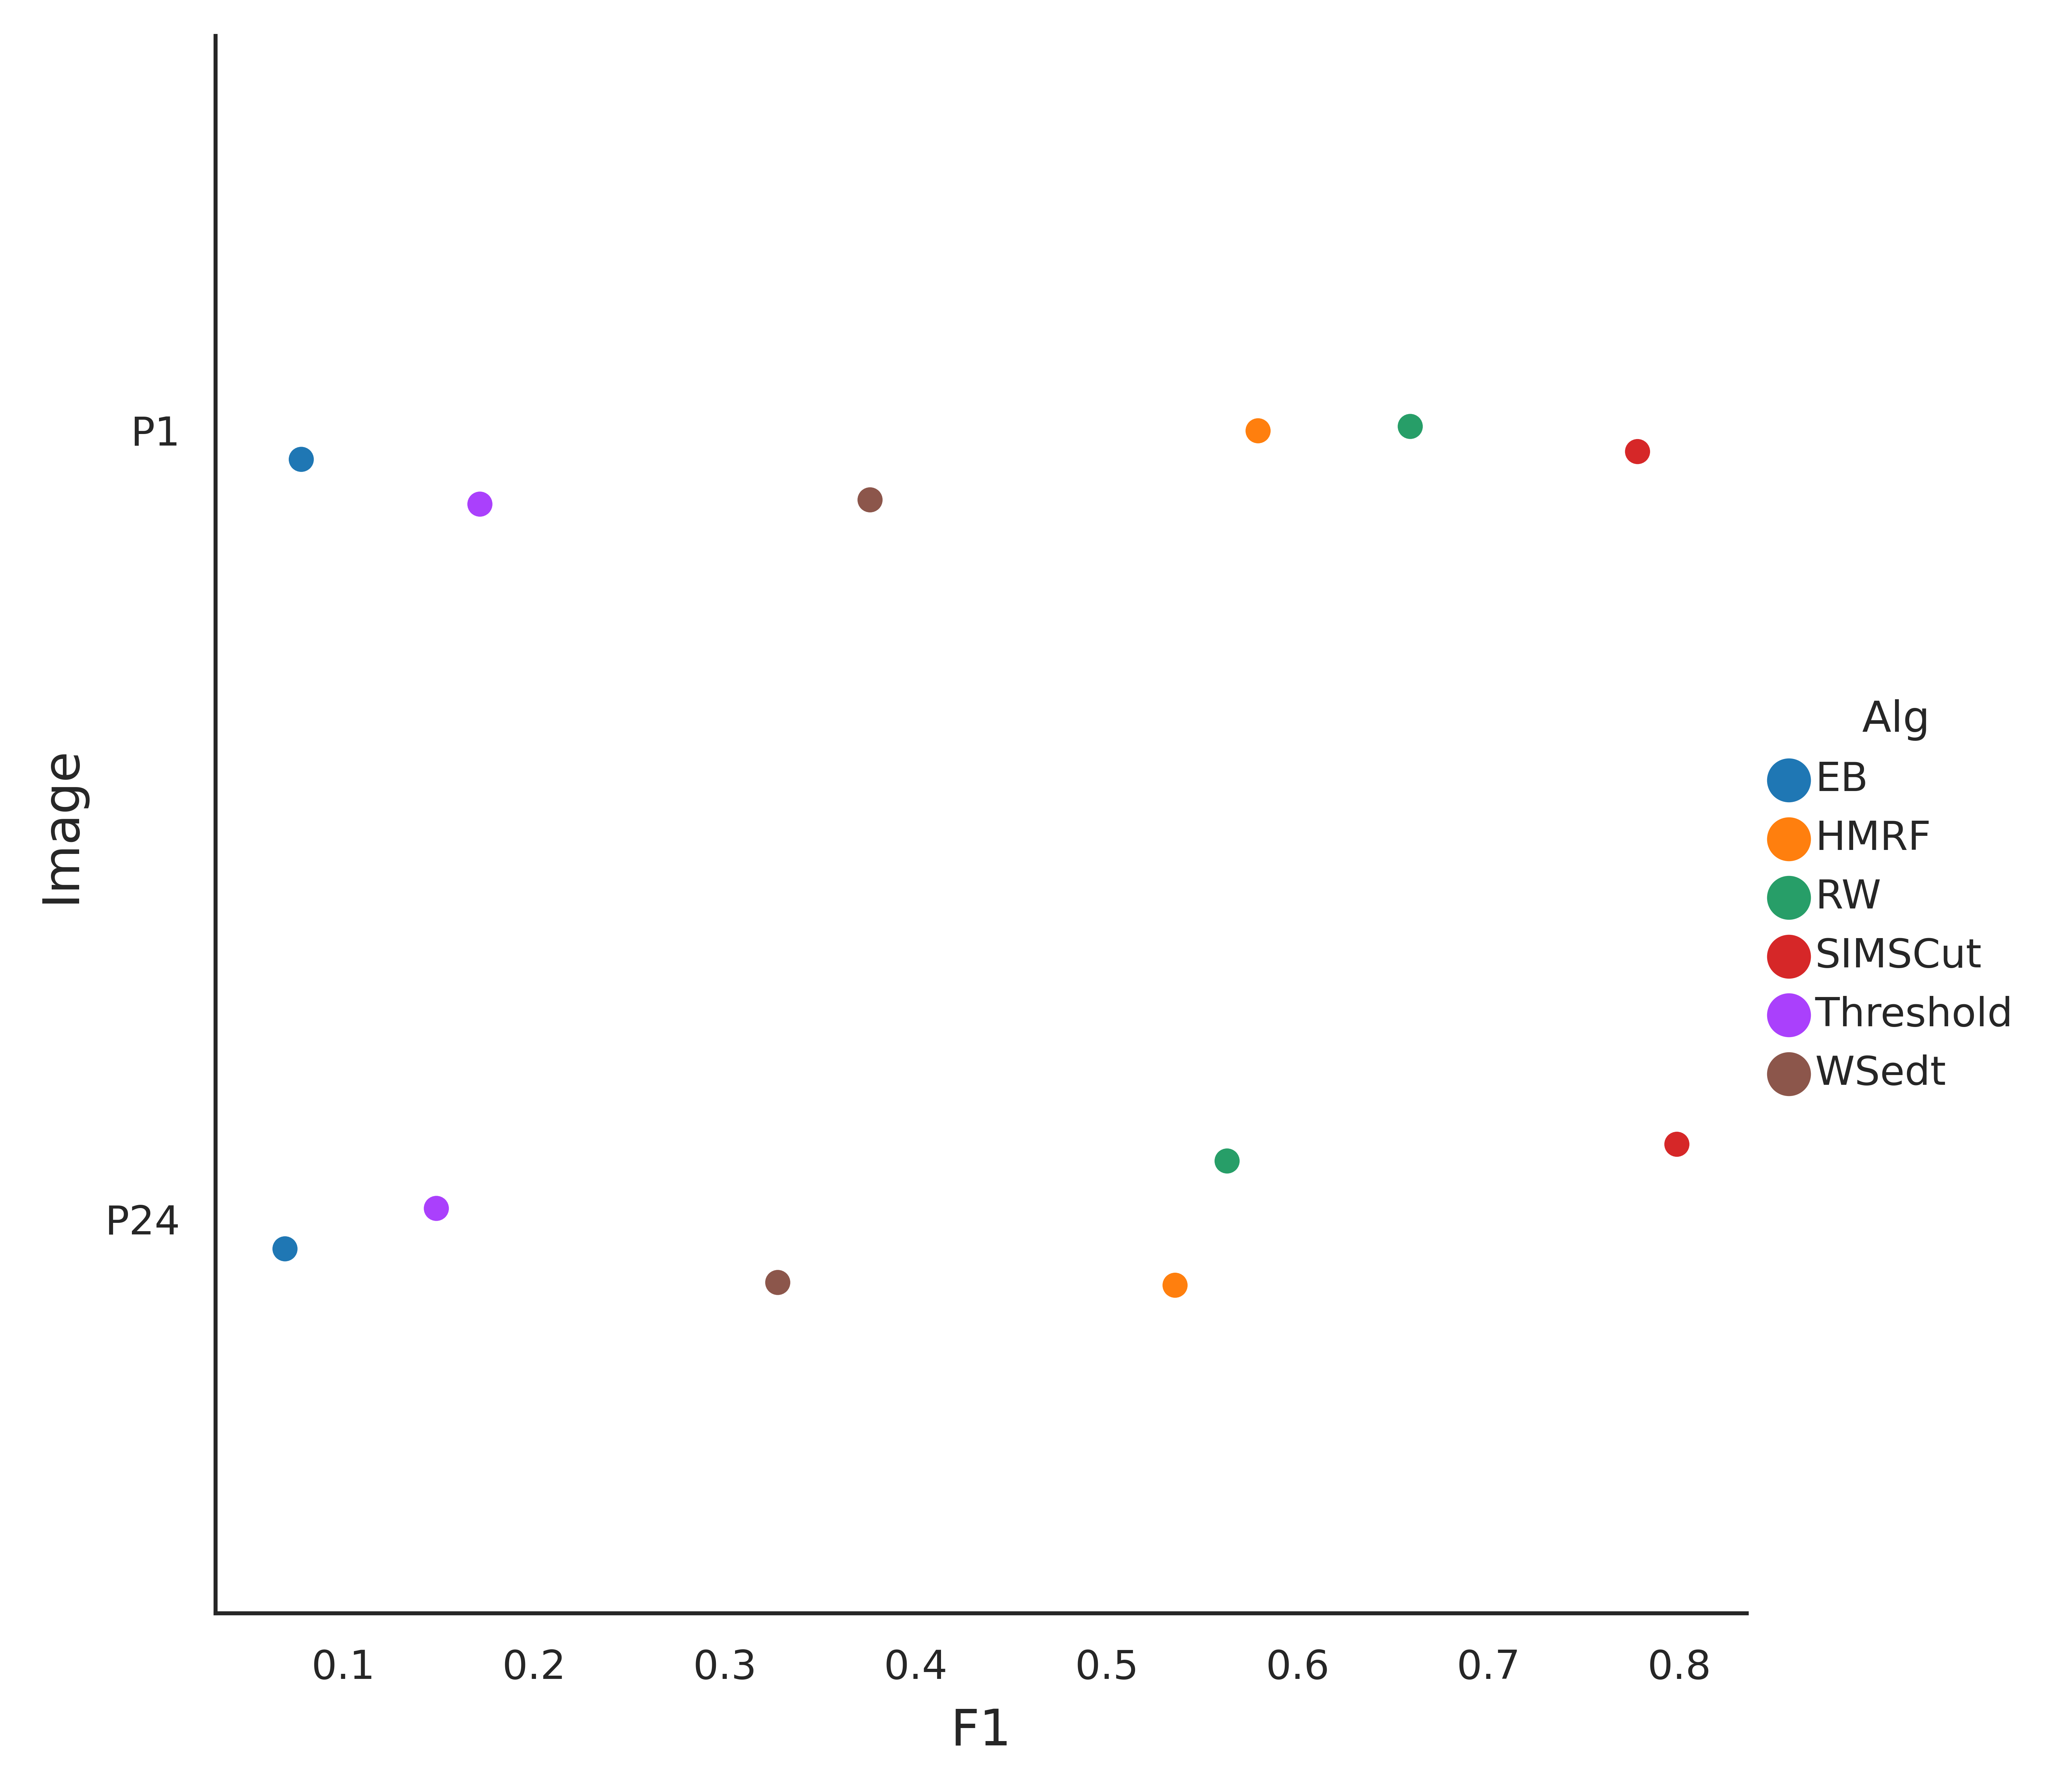

In [8]:
results = pd.DataFrame({'Image':[],'Type':[],'Alg':[],'Parameter':[],'Threshold':[],'AP':[],'F1':[],'Jaccard':[],'TP':[],'FP':[],'FN':[],'Count':[]})

for i in range(len(tissue_list)):
    test_tissue = tissue_list[i]
    cur_human = Human_int_dict[test_tissue]
    cur_type = type_list[i]
    for alg in Alg_dict.keys():
#     for alg in ['SIMSCut']:

        cur_rst_dict = Alg_dict[alg]
        
        cur_tissue_dict = cur_rst_dict[test_tissue]
#             cur_tissue_dict is either a numpy matrix or a dict
        if isinstance(cur_tissue_dict,np.ndarray):
            cur_int = cur_tissue_dict
#             if cur_type=='CellLine':
#                 cur_int = filter_mask(cur_int,threshold=(0,60))
#             else:
#                 cur_int = filter_mask(cur_int,threshold=(0,20))
                
            k=-1
            
            print('{0} {1} {2}'.format(test_tissue,alg,k))
            count = np.unique(cur_int).shape[0]-1
            results = compute_af1_results(cur_human, cur_int, results, test_tissue,alg,k,count,cur_type)
#             results = compute_af1_results( cur_int,cur_human, results, test_tissue,alg,k,count)

        elif isinstance(cur_tissue_dict,dict):
            for k in cur_tissue_dict.keys():
                cur_int = cur_tissue_dict[k]
#                 cur_int = filter_mask(cur_int,threshold=(0,20))
#                 if cur_type=='CellLine':
#                     cur_int = filter_mask(cur_int,threshold=(0,60))
#                 else:
#                     cur_int = filter_mask(cur_int,threshold=(0,20))
              
                print('{0} {1} {2}'.format(test_tissue,alg,k))
                count = np.unique(cur_int).shape[0]-1
                
                results = compute_af1_results(cur_human, cur_int, results, test_tissue,alg,k,count,cur_type)
#                 results = compute_af1_results( cur_int,cur_human, results, test_tissue,alg,k,count)
                
                    
rst_agg = results[results.Threshold>=0.1].groupby(['Image','Alg'], as_index=False).agg({"F1": 'max'})

# filter(0,20) UOI>=0.05
g = sns.catplot(y="Image", x="F1", hue="Alg",order=tissue_list,orient='h',
                 data=rst_agg)
        
        
        
        


In [10]:
cmp_bold = palettable.cartocolors.qualitative.Bold_10.mpl_colors
cmp_use = [cmp_bold[4],cmp_bold[0],cmp_bold[1],cmp_bold[2],cmp_bold[3],cmp_bold[5]]
hue_order = ['SIMSCut','EB','HMRF','RW','Threshold','WSedt']
g = sns.catplot(
    data=rst_agg[rst_agg.Alg!='WSgrad'], kind="bar",
    x="F1", y="Image", hue="Alg",aspect=1,
    ci="sd", alpha=1, height=6,order=tissue_list,palette=cmp_use,
    orient='h',hue_order=hue_order
)
g.despine(left=True)
g.set_axis_labels("Sample", "F-score")
# g.legend.set_title("")